In [1]:
import awkward as ak
import numpy as np
import time
# print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import mplhep as hep
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

from python.plugins import runCoffeaJob
from python.triggerProcessor import triggerProcessor, applyPrescales
from dask.distributed import Client

In [3]:
# in_year = '2016APV'
# data_bool = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     # filename = "datasets_UL_NANOAOD.json"
#     filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, casa = False, dask = False, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignment_{}_{}_{}_test.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [4]:
from scipy.optimize import minimize, curve_fit
from scipy.stats import rv_continuous, norm
from scipy.special import erf, erfinv

def fit_function(x, b, c):
    # y = a+0.5*(1-a)*(1+erf((x-b)/c))
    y = 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    return y
#### define custom error function using scipy.stats rv_continuous --> will automatically inherit MLE fit

class cust_erf(rv_continuous):
    def _pdf(self, x, b, c):
        # return a+0.5*(1-a)*(1+erf((x-b)/c))
        return 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    #### use rv_continuous scale and loc to compute x->(x-loc)/scale
fit_func = cust_erf(name='erf')
print("rv_cont fit function: ", fit_func)

#### params are b,c
                      
                      
def fit_trigEff(x, data):
    #x is the pt bin centers; data is the efficiency values
    x0 = [np.min(x), np.min(x)/5]
    popt, pcov = curve_fit(fit_function, x, data, p0 = x0)
    # b, c, loc, scale = fit_func.fit(data, *popt, floc = 0., fscale = 1.0)
    print("Basic fit results: ", popt)
    return popt

import matplotlib.pyplot as plt
plt.style.use([hep.style.CMS, hep.style.firamath])
import hist 
from python.plugins import checkdir
def plot_turnOn(result, HLT):
    hist_trigEff = result['hist_trigEff_ptCut']
    hist_trigRef = result['hist_trigRef']
    hist_pt = result['hist_pt']
    HLT_paths = [path for path in list(hist_trigEff.project("HLT_cat").axes[0])]
    dataset = hist_trigEff[{"HLT_cat":slice(0,hist.overflow-1,sum)}].axes[0][0]
    os_path = 'plots/triggerStudies'+ dataset+'/'
    checkdir(os_path)
    print('HLT_paths:', HLT_paths)
    trigThresh = [int(path.replace(HLT, '')) for path in HLT_paths]
    turnOnPts = {}
    turnOnPts_ptCut = {}
    for i in np.arange(len(HLT_paths)):
        path = HLT_paths[i]
        print("Path = ", path)
        print("dataset: ", dataset)
        # print("trigeffvalues for path: ", hist_trigEff[{"HLT_cat":path}])
        #### numerator is number of events that belong to trigger path below and have pt > current trigger thresh
        numerator = hist_trigEff[{"HLT_cat":path}].values()[0]
        #### denominator is number of events in trigger below
        denominator = hist_trigRef[{"HLT_cat":path}].values()[0]
        num = numerator[denominator > 0]
        denom = denominator[denominator > 0]
        efficiency = num / denom
        pt_centers = hist_trigEff.axes['pt'].centers[denominator > 0]
        print("Pt centers: ", pt_centers)
        print("Length of efficiency:", len(efficiency))
        #### plot original numerator and denominator histograms
        fig, ax = plt.subplots(1, 1)
        hist_trigEff[{"HLT_cat":path}].plot1d(ax=ax)
        hist_trigRef[{"HLT_cat":path}].plot1d(ax=ax)
        ax.set_title("Events in HLT " + HLT_paths[i-1])
        ax.set_xlabel("Leading Jet pT (GeV)")
        ax.set_ylim(1, None)
        ax.legend(["Numerator", "Numerator_ptCut", "Denominator"])
        plt.savefig(os_path + 'numDenom_HLT_' + path + ".png")
        #### Make custom fit function for the efficiencies
        if len(efficiency) > 0:
            fig, ax = plt.subplots(1, 1)
            ax.set_ylim([-0.01, 1.1])
            ### only fit points after trigger threshold
            eff_turnon_id = np.min(np.argwhere(trigThresh[i] <= pt_centers))
            xdata = pt_centers[eff_turnon_id+3:-1]
            print("pt start: ", pt_centers[eff_turnon_id])
            ydata = efficiency[eff_turnon_id+3:-1]
            popt = fit_trigEff(xdata, ydata)
            # b_mle, c_mle, popt = fit_trigEff(pt_centers, efficiency)
            xpts = np.linspace(pt_centers[eff_turnon_id], 2400, int((2400-pt_centers[eff_turnon_id])))
            ### turn on point is pt value when efficiency reaches 0.99 --> solve fitted equation
            b, c = popt
            xdata = pt_centers[eff_turnon_id:-1]
            ydata = efficiency[eff_turnon_id:-1]
            def NLL(params):
                b = params[0]
                c = params[1]
                y = 0.5*(1+erf((xdata-b)/(np.sqrt(2)*c)))
                return -1*norm(y, params[2]).logpdf(ydata).sum()
            # res = minimize(NLL, np.append(popt,[1]))
            res = minimize(NLL, [np.min(xdata), np.min(xdata)/5, 1])
            b_mle, c_mle, s_mle = res.x
            to_pt = (np.sqrt(2)*c*erfinv(2*0.99-1)) + b
            to_pt_mle = (np.sqrt(2)*c_mle*erfinv(2*0.99-1)) + b_mle
            turnOnPts[path] = [to_pt, to_pt_mle]
            ax.scatter(hist_trigEff.axes['pt'].centers[denominator > 0], efficiency, label = 'HLT_' + path)
            ax.plot(xpts, fit_function(xpts, *popt), label = "Curve fit; to_pt = %.f"%to_pt)
            ax.plot(xpts, fit_function(xpts, b_mle, c_mle), label = "MLE fit; to_pt = %.f"%to_pt_mle)
            ax.set_xlabel("Leading Jet pT (GeV)")
            ax.legend()
            plt.savefig(os_path + 'efficiency_HLT_' + path + ".png")
    #### plot total leading jet pt for reference
    fig, ax = plt.subplots(1, 1)
#     hist_pt.plot1d(ax=ax)
    pt_hist = hist_trigEff[{"dataset":sum}]
    pt_hist.plot1d(ax=ax, overlay="HLT_cat", stack = True)
    ax.set_title("All events")
    ax.set_xlabel("Leading Jet pT (GeV)")
    ax.set_ylim(1, None)
    ax.set_xlim([180., 3200.])
    plt.legend()
    plt.savefig(os_path + 'HLT_' + path + ".png")
    
    return turnOnPts

rv_cont fit function:  <__main__.cust_erf object at 0x7fa5f890bb50>


In [5]:
# HLT = 'PFJet'
# with open("coffeaOutput/triggerAssignment_JetHT_2016APV_PFJettest.pkl", "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT)
# print(turnOnPts)

In [6]:
# HLT = 'AK8PFJet'
# with open("coffeaOutput/triggerAssignment_QCDsim_2017_AK8PFJet_NewHist.pkl", "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT)
# print(turnOnPts)

In [7]:
# HLT = 'AK8PFJet'
# result = util.load('coffeaOutput/triggerAssignment_QCDsim_2017_AK8PFJet_NewHist.coffea')
# turnOnPts = plot_turnOn(result, HLT)
# print(turnOnPts)

In [8]:
JetHT2016APV_ver2 = {'PFJet40': 0.,
                     'PFJet60': 0., 
                     'PFJet80': 0., 
                     'PFJet140': 270., 
                     'PFJet200': 360., 
                     'PFJet260': 420.,
                     'PFJet320': 500., 
                     'PFJet400': 620., 
                     'PFJet450': 680., 
                     'PFJet500': 750.}

newnew2016APV = {'AK8PFJet60': [-907.8640999961028, 262.4735999003504], 'AK8PFJet80': [-813.8186499329943, 262.77245946851093], 
 'AK8PFJet140': [253.94444973912857, 263.3026984698921], 'AK8PFJet200': [360.0764064058382, 299.2854716580488], 
      'AK8PFJet260': [483.00287488418155, 404.4448541480781], 'AK8PFJet320': [516.4663396055998, 474.8250139929101], 
      'AK8PFJet400': [633.6486082346614, 615.3673978541681], 'AK8PFJet450': [696.4518929273487, 685.7016389352334], 
      'AK8PFJet500': [747.6266419662311, 756.0433505701444]}
newnew2016 = {'AK8PFJet60': [-946.2357202500248, 261.7098144410188], 'AK8PFJet80': [-803.2295016490575, 262.5218607414522],
              'AK8PFJet140': [-858.7030992093493, 263.265890230311], 'AK8PFJet200': [413.00735585819587, 299.410005622084], 
              'AK8PFJet260': [459.14663820030887, 404.4577393342188], 'AK8PFJet320': [515.2366802858614, 474.8650088075158], 
              'AK8PFJet400': [637.7194912921713, 615.3824932019286], 'AK8PFJet450': [692.9761938054255, 685.7182502373848], 
              'AK8PFJet500': [747.2057802913281, 756.0628352446492]}
newnew2017 = {'AK8PFJet80': [-888.8257856276085, 262.90302280290547], 'AK8PFJet140': [268.4972055097363, 263.4973288928351], 
              'AK8PFJet200': [361.8933122586835, 299.2525901052801], 'AK8PFJet260': [446.46778027594905, 404.51157859921364], 
              'AK8PFJet320': [514.0152556774021, 474.94177990800785], 'AK8PFJet400': [633.369090255502, 615.465068235013], 
              'AK8PFJet450': [685.9223126308343, 685.7690678042886], 'AK8PFJet500': [743.9267302139867, 756.1055054574387], 
              'AK8PFJet550': [795.7010491595948, 826.4498999990128], 'AK8PFJet60': [-833.5216610826582, 262.3418152112348]}
newnew2018 = {'AK8PFJet60': [-811.0145179581602, 263.0901583141537], 'AK8PFJet80': [-827.6171539282988, 263.2594121656277], 
              'AK8PFJet140': [281.81975103728195, 263.58429273913055], 'AK8PFJet200': [367.6531123322325, 299.12181095332636], 
              'AK8PFJet260': [458.9796186587356, 404.5000154037815], 'AK8PFJet320': [523.0660904166687, 474.87960485319854], 
              'AK8PFJet400': [638.7502963687823, 615.4428384628924], 'AK8PFJet450': [689.7766784490543, 685.770116976563], 
              'AK8PFJet500': [745.1851326682686, 756.1016601517806], 'AK8PFJet550': [796.7749788024962, 826.4330586079827]}
JetHT2016_new = {'AK8PFJet40':0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 0., 
                 'AK8PFJet140': 260., 
                 'AK8PFJet200': 360., 
                 'AK8PFJet260': 450., 
                 'AK8PFJet320': 500., 
                 'AK8PFJet400': 630., 
                 'AK8PFJet450': 690., 
                 'AK8PFJet500': 750.}
JetHT2016APV_new = {'AK8PFJet40':0., 
                     'AK8PFJet60': 0, 
                     'AK8PFJet80': 0, 
                     'AK8PFJet140': 260., 
                     'AK8PFJet200': 360., 
                     'AK8PFJet260': 450., 
                     'AK8PFJet320': 500., 
                     'AK8PFJet400': 630., 
                     'AK8PFJet450': 690., 
                     'AK8PFJet500': 750.}
JetHT2017_new = {'AK8PFJet40':0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 0., 
                 'AK8PFJet140': 265., 
                 'AK8PFJet200': 360., 
                 'AK8PFJet260': 440., 
                 'AK8PFJet320': 500., 
                 'AK8PFJet400': 630., 
                 'AK8PFJet450': 685., 
                 'AK8PFJet500': 750., 
                 'AK8PFJet550': 800.}
JetHT2018_new = {'AK8PFJet15': 0.,
                 'AK8PFJet25': 0.,
                 'AK8PFJet40': 0.,
                 'AK8PFJet60': 0.,
                 'AK8PFJet80': 0., 
                 'AK8PFJet140': 265., 
                 'AK8PFJet200': 360., 
                 'AK8PFJet260': 450., 
                 'AK8PFJet320': 500., 
                 'AK8PFJet400': 630., 
                 'AK8PFJet450': 685., 
                 'AK8PFJet500': 750., 
                 'AK8PFJet550': 800.}



turnOnPts_2016_QCDflat = {'AK8PFJet40':0.,
                          'AK8PFJet60': 106.79400044725446, 
                          'AK8PFJet80': 169.96352855878737, 
                          'AK8PFJet140': 265.2873364497926, 
                          'AK8PFJet200': 315.1712855987987, 
                          'AK8PFJet260': 385.9414264230047, 
                          'AK8PFJet320': 456.1785495557566, 
                          'AK8PFJet400': 528.4054384945691, 
                          'AK8PFJet450': 599.9567915817205, 
                          'AK8PFJet500': 671.8599581978826}

turnOnPts_2017_QCD_flat = {'AK8PFJet40':0.,
                           'AK8PFJet60': 78.72682467365811, 
                           'AK8PFJet80': 114.26008394028244, 
                           'AK8PFJet140': 262.69051582382326, 
                           'AK8PFJet200': 315.5082701033607, 
                           'AK8PFJet260': 391.2706193753585, 
                           'AK8PFJet320': 461.86703035451836, 
                           'AK8PFJet400': 545.2806371181599, 
                           'AK8PFJet450': 611.8168127002015, 
                           'AK8PFJet500': 681.8828608405956, 
                           'AK8PFJet550': 725.799090910656}

turnOnPts_2018_QCDflat = {'AK8PFJet15': 0.,
                          'AK8PFJet25': 0.,
                          'AK8PFJet40': 0.,
                          'AK8PFJet60': 0.,
                          'AK8PFJet80': 0.,
                          'AK8PFJet140': 255.02381002773194, 
                          'AK8PFJet200': 313.2026733979357, 
                          'AK8PFJet260': 388.2175317071178, 
                          'AK8PFJet320': 459.1304096129003, 
                          'AK8PFJet400': 530.7709332894112, 
                          'AK8PFJet450': 599.485074238053, 
                          'AK8PFJet500': 669.532328119605, 
                          'AK8PFJet550': 706.4936306567531}

In [9]:
in_year = '2016'
data_bool = True
winterfell = False
processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2016APV_new.values())), data = data_bool)
datastring = "JetHT" if processor.data == True else "QCDsim"
if processor.data==False and winterfell:
    filename = "QCD_flat_files.json"
elif processor.data==False:
    filename = "fileset_QCD.json"
else:
    filename = "datasets_UL_NANOAOD.json"
result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False , year = processor.year, data = processor.data)
with open('coffeaOutput/applyPrescales_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
    pickle.dump( result, f)

Running on LPC Condor
[                                        ] | 0% Completed |  0.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 61000245.0: TOOL at 131.225.189.79 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/lmhay/tmpmfp08fs5/correctionFiles/JEC/Summer19UL17_V5_MC/Summer19UL17_V5_MC_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/245/0/cluster61000245.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL17_V5_MC/Summer19UL17_V5_MC_UncertaintySources_AK8PF.junc.txt


[                                        ] | 0% Completed |  9.2s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 61000246.0: TOOL at 131.225.189.79 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/lmhay/tmpmfp08fs5/correctionFiles/JEC/Summer19UL18_RunD_V5_DATA/Summer19UL18_RunD_V5_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/246/0/cluster61000246.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunD_V5_DATA/Summer19UL18_RunD_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt


[                                        ] | 0% Completed | 15.4s

Task exception was never retrieved
future: <Task finished name='Task-483' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError
Task exception was never retrieved
future: <Task finished name='Task-484' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert

{'hist_pt': Hist(########################] | 100% Completed | 21min 38.8s
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=3.26205e+07, variance=3.26205e+07) (WeightedSum(value=3.26221e+07, variance=3.26221e+07) with flow), 'hist_pt_byHLTpath': Hist(
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=2.37949e+09, variance=1.07273e+14) (WeightedSum(value=2.37949e+09, variance=1.07273e+14)

In [10]:
in_year = '2016APV'
data_bool = True
winterfell = True
processor = applyPrescales(year = in_year, trigger = 'PFJet', turnOnPts = np.array(list(JetHT2016APV_ver2.values())), data = data_bool)
datastring = "JetHT" if processor.data == True else "QCDsim"
if processor.data==False and winterfell:
    filename = "QCD_flat_files.json"
elif processor.data==False:
    filename = "fileset_QCD.json"
else:
    filename = "datasets_JetHT_NOAK8PFHLT.json"
result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False, year = processor.year, data = processor.data)
with open('coffeaOutput/applyPrescales_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
    pickle.dump( result, f)

Running on LPC Condor
[                                        ] | 0% Completed | 30.3s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 61000343.0: TOOL at 131.225.189.79 failed to send file(s) to <131.225.189.168:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/lmhay/tmp_mqcd4bw/correctionFiles/JEC/Summer19UL18_RunD_V5_DATA/Summer19UL18_RunD_V5_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.168 - |Error: receiving file /storage/local/data1/condor/spool/343/0/cluster61000343.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL18_RunC_V5_DATA/Summer19UL18_RunC_V5_DATA_UncertaintySources_AK8PFPuppi.junc.txt
Task exception was never retrieved
future: <Task finished name='Task-104012' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distri

{'hist_pt': Hist(########################] | 100% Completed | 17min 36.3s
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['PFJet500', 'PFJet450', 'PFJet400', 'PFJet320', 'PFJet260', 'PFJet200', 'PFJet140', 'PFJet80', 'PFJet60', 'PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=2.01545e+07, variance=2.01545e+07) (WeightedSum(value=2.01626e+07, variance=2.01626e+07) with flow), 'hist_pt_byHLTpath': Hist(
  StrCategory(['JetHT'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['PFJet500', 'PFJet450', 'PFJet400', 'PFJet320', 'PFJet260', 'PFJet200', 'PFJet140', 'PFJet80'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.34987e+09, variance=1.313e+13) (WeightedSum(value=1.34987e+09, variance=1.313e+13) with flow), 'cutflow': defaultdict_accumulator(<class 'in

In [11]:
def plotPrescales(result, year):
    hist_pt = result['hist_pt'][{'dataset':sum}]
    hist_pt_byHLTpath = result['hist_pt_byHLTpath'][{'dataset':sum}]
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams["figure.figsize"] = (20,10)
    fig, axs = plt.subplots(1, 2)      
    print(hist_pt)

    hist_pt.plot(ax = axs[0], overlay='HLT_cat')
    axs[0].set_yscale('log')
    axs[0].set_ylim([0.0, 1.0e10])
    axs[0].set_title('Events sorted by HLT w/ prescale applied')

    hist_pt_byHLTpath.plot(ax = axs[1], overlay='HLT_cat', stack=False, histtype='errorbar')
    axs[1].set_yscale('log')
    axs[1].set_ylim([0.0, 1.0e10])
    axs[1].set_title('Doubles removed w/ prescale applied')

    fig.suptitle('Apply Prescales ' + str(year), fontsize="large")

    plt.rc('legend',fontsize='small')
    plt.legend()
    dataset = 'JetHT' + str(year)
    os_path = 'plots/triggerStudies'+ dataset + '/'
    checkdir(os_path)
    plt.savefig(os_path + 'applyPrescales' + str(year) + ".png")


Hist(
  StrCategory(['PFJet500', 'PFJet450', 'PFJet400', 'PFJet320', 'PFJet260', 'PFJet200', 'PFJet140', 'PFJet80', 'PFJet60', 'PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=481557, variance=481557) (WeightedSum(value=481677, variance=481677) with flow)


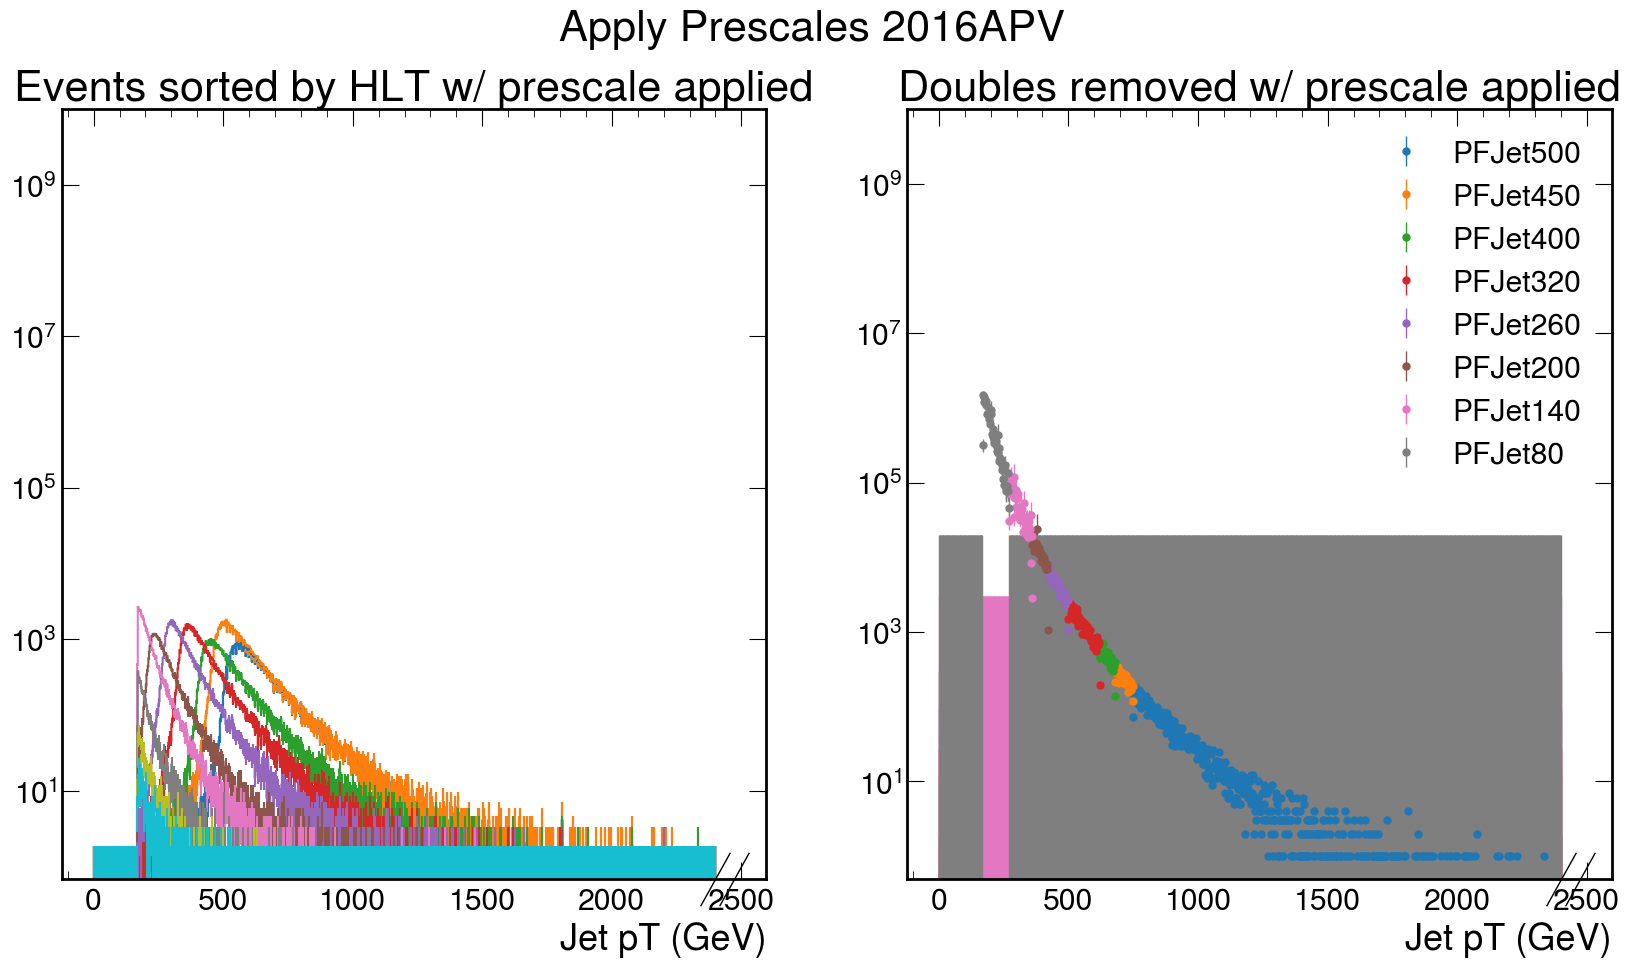

In [12]:
with open("coffeaOutput/applyPrescales_JetHT_2016APV_PFJet.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2016APV')

In [13]:
# with open("coffeaOutput/applyPrescales_JetHT_2016_AK8PFJet_NewHist.pkl", "rb") as f:
#     result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
# plotPrescales(result, '2016')

In [14]:
# with open("coffeaOutput/applyPrescales_JetHT_2017_AK8PFJet_NewHist.pkl", "rb") as f:
#     result = pickle.load( f )
# # print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
# plotPrescales(result, '2017')

Hist(
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=5.64651e+07, variance=5.64651e+07) (WeightedSum(value=5.64689e+07, variance=5.64689e+07) with flow)


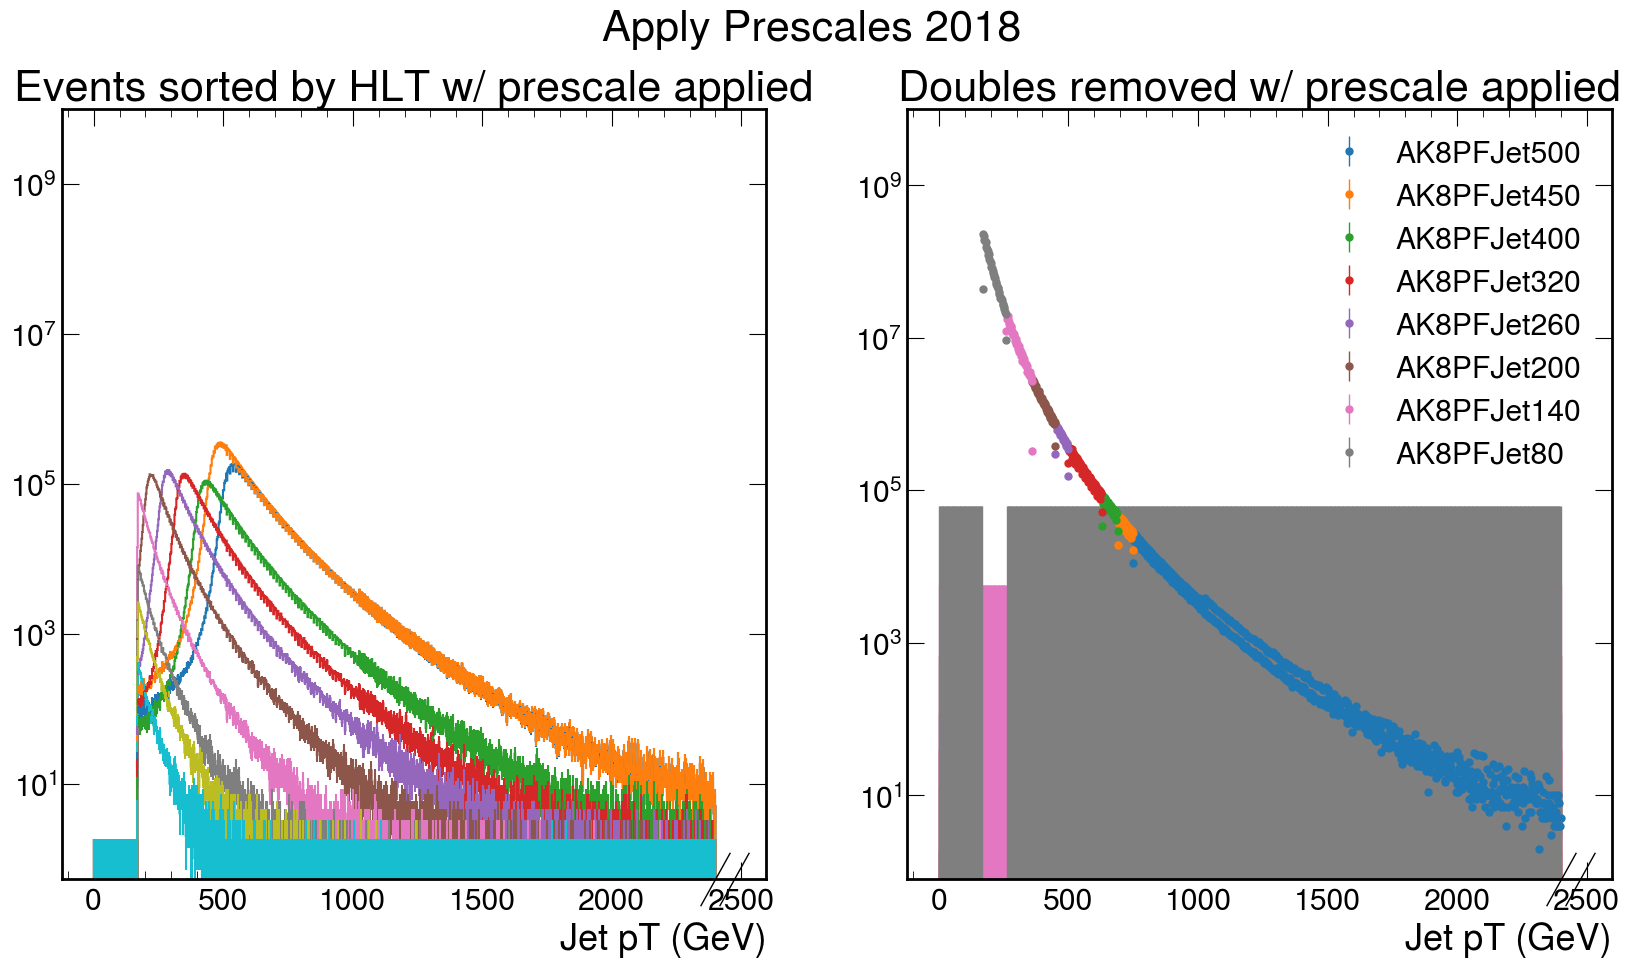

In [15]:
with open("coffeaOutput/applyPrescales_JetHT_2016APV_AK8PFJet.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2018')